In [1]:
from tqdm import tqdm
from convokit import Corpus, User, Utterance

## Creating Users

In [6]:
data_dir = "C:/Users/Di Ni/Desktop/Courses/CS6742NLPandSocialInteration/full_info.csv"

In [7]:
anno_dir = "C:/Users/Di Ni/Desktop/Courses/CS6742NLPandSocialInteration/300_info.xlsx"

The full PersuasionForGood dataset contains two files:
    full_info.csv
    full_dialog.csv
The metadata for each of the users are contained in the full_info.csv file. 
The first five columns of each line include information about the dialogue that the user is a part of. Because a user can be involved in multiple dialogues, each dialogue is a key within the user metadata which retreives the role, donation amount and number of turn associated with the user within a specific dialogue. The rest of the entries correspond to the 23 dimensional feature vector associated with each user. 

Additionally, the dictionary diag_to_user is used so that the users can be searched with just a dialogue ID and role. This is because the full_dialog.csv file only has the dialogue id and not the user_ids of the participating users. 

In [8]:
from collections import defaultdict
user_meta = defaultdict(dict)
first = True
headers = None
diag_to_user = {}
diag_meta = {}
roles = ["persuader","persuadee"]
with open(data_dir, "r", encoding='utf-8', errors='ignore') as f:
    for line in f:          
        info = line.split(",")
        if first:
            #Getting the headers of the personality vector
            headers = info[5:]
            first = False
        else:
            diag_to_user[(info[0],info[2])] = info[1]
            if info[0] in diag_meta:
                diag_meta[info[0]][roles[int(info[2])]] = info[1]
            else:
                diag_meta[info[0]] = {"donation_amt": info[3],
                                      "num_turns": info[4],
                                      "intended_amt": None}
                diag_meta[info[0]][roles[int(info[2])]] = info[1]
            if info[1] not in user_meta:
                for i, heading in enumerate(headers):
                    user_meta[info[1]][heading] = info[i+5]

In [421]:
# diag_meta

In [11]:
import pandas as pd
anno_info = pd.read_excel(anno_dir) 
# anno_info

In [12]:
for line in anno_info.values:          
    if line[2] == 1:
        diag_meta[info[0]]["intended_amt"] = line[3]

In [13]:
corpus_users = {k: User(name = k, meta = v) for k,v in user_meta.items()}

In [14]:
print("number of users in the data = {0}".format(len(corpus_users)))

number of users in the data = 1285


## Creating Utterances

Utterances can be found in the full_dialog.csv, with 20932 lines total. The raw data has four columns: <br>
"Unit" is the text of the utterance.  <br>
"Turn" is the turn of the utterance; for example, the first back and forth between persuader and persuadee would both have "Turn" = 0.  <br>
"B2" is the conversation ID. <br>
"B4" is the role of the user in this utterance, persuader(0) or persuadee (1). <br>

As per the utterance object, we give each utterance a unique id and the unique user ID is found using a dictionary which takes in the conversation ID and role of user. The metadata for each utterance includes both the turn and role  of user. 

In [20]:
import pandas as pd
utterance_data = pd.read_csv("C:/Users/Di Ni/Desktop/Courses/CS6742NLPandSocialInteration/full_dialog.csv") 
# utterance_data

In [21]:
len(diag_to_user)

2034

In [22]:
utterance_corpus = {}
convo_order = utterance_data["Unnamed: 0"]
dia_to_id = {}

for i in list(range(len(utterance_data))):
    utterance_data_line = utterance_data.loc[i, :]
    B2 = utterance_data_line["B2"]
    B4 = utterance_data_line["B4"]
    Text = utterance_data_line["Unit"]
    meta = {"role": B4, "turn_index": utterance_data_line["Turn"], "dialogue_id" : B2, "er_label_1": None, "ee_label_1": None, "er_label_2": None, "er_label_2": None,"neg": None, "neu": None, "pos": None}
    
    if utterance_data_line["Unnamed: 0"] == 0:
        ReplyTo = None
    else:  
        ReplyTo = i - 1
    if utterance_data_line["Unnamed: 0"] == 0:
        Root = i
    else:
        utter_id = list(range(0, i+1))
        convo_order_sub = convo_order.loc[0:i]
        df = pd.DataFrame({"utter_id": utter_id, "convo_order_sub":convo_order_sub})
        df2 = df[df["convo_order_sub"] == 0]
        Root = df2['utter_id'].max()
    utterance_corpus[i] = Utterance(i, corpus_users[diag_to_user[(B2,str(B4))]], Root, ReplyTo, None, Text, meta=meta)
    dia_to_id[(B2,B4,utterance_data_line["Turn"])] = i

In [23]:
utterance_corpus[0].meta

{'role': 0,
 'turn_index': 0,
 'dialogue_id': '20180904-045349_715_live',
 'er_label_1': None,
 'ee_label_1': None,
 'er_label_2': None,
 'neg': None,
 'neu': None,
 'pos': None}

In [24]:
import numpy as np

In [26]:
anno_utterances = pd.read_excel("C:/Users/Di Ni/Desktop/Courses/CS6742NLPandSocialInteration/300_dialog.xlsx") 
anno_utterances.values[pd.isna(anno_utterances.values)] = None

In [29]:
for line in anno_utterances.values:
    if not pd.isna(line[5-1]):
        utterance_corpus[dia_to_id[(line[1-1],line[2-1],line[3-1])]].meta["er_label_1"] = line[5-1]
    if not pd.isna(line[6-1]):
        utterance_corpus[dia_to_id[(line[1-1],line[2-1],line[3-1])]].meta["e2_label_1"] = line[6-1]
    if not pd.isna(line[7-1]):
        utterance_corpus[dia_to_id[(line[1-1],line[2-1],line[3-1])]].meta["er_label_2"] = line[7-1]
    if not pd.isna(line[8-1]):
        utterance_corpus[dia_to_id[(line[1-1],line[2-1],line[3-1])]].meta["ee_label_2"] = line[8-1]
    if not pd.isna(line[9-1]):
        utterance_corpus[dia_to_id[(line[1-1],line[2-1],line[3-1])]].meta["neg"] = line[9-1]
    if not pd.isna(line[10-1]):
        utterance_corpus[dia_to_id[(line[1-1],line[2-1],line[3-1])]].meta["neu"] = line[10-1]
    if not pd.isna(line[11-1]):
        utterance_corpus[dia_to_id[(line[1-1],line[2-1],line[3-1])]].meta["pos"] = line[11-1]
        

##  Creating corpus from utterances

In [30]:
utterance_list = [utterance for k, utterance in utterance_corpus.items()]

In [31]:
persuasion_corpus = Corpus(utterances=utterance_list, version=1)

In [32]:
print("number of conversations in the dataset = {}".format(len(persuasion_corpus.get_conversation_ids())))

number of conversations in the dataset = 1017


In [422]:
# convo_ids = persuasion_corpus.get_conversation_ids()
# for i, convo_idx in enumerate(convo_ids[0:5]):
#     print("sample conversation {}:".format(i))
#     print(persuasion_corpus.get_conversation(convo_idx).get_utterance_ids())

In [73]:
for conversation in persuasion_corpus.conversations.values():
    conversation.meta = diag_meta[conversation.get_utterance(conversation._utterance_ids[0]).meta['dialogue_id']]

In [37]:
from convokit import Parser

In [38]:
annotator = Parser()

In [39]:
movie_corpus = annotator.fit_transform(persuasion_corpus)

In [40]:
persuasion_corpus = movie_corpus

In [41]:
from convokit import PolitenessStrategies

In [42]:
ps = PolitenessStrategies()
persuasion_corpus = ps.transform(persuasion_corpus)

In [381]:
from collections import Counter
seen = Counter()
counts = Counter()
donations = {}
polite_strategies = list(persuasion_corpus.utterances[0].meta['politeness_strategies'].keys())
polite_score = [Counter() for ps in range(len(polite_strategies))]
for utterance in persuasion_corpus.utterances.values():
    if utterance.meta['role'] == 0:
        for i, ps in enumerate(polite_strategies):
            polite_score[i][utterance.meta['dialogue_id']] += utterance.meta['politeness_strategies'][ps]
        counts[utterance.meta['dialogue_id']] +=1

        for conv in persuasion_corpus.conversations.values():
            if utterance.id in conv._utterance_ids:
                donations[utterance.meta['dialogue_id']] = conv._meta['donation_amt']

In [408]:

df1 = pd.DataFrame()
for index, ps in enumerate(polite_strategies):
#     print('the', index, 'th strategy is', ps)
    df = pd.DataFrame.from_dict(polite_score[index], orient='index').reset_index().rename(columns={'index':'dialogue_id', 0:ps})
    df1[ps] = df[ps]
df1['dialogue_id'] = df['dialogue_id']
df1['donation_amt']= donations.values()
cols = df1.columns.tolist()
cols = cols[-2:]+cols[:-2]
df1 = df1[cols]
df1
# donations

,dialogue_id,donation_amt,feature_politeness_==Please==,feature_politeness_==Please_start==,feature_politeness_==Indirect_(btw)==,feature_politeness_==Hedges==,feature_politeness_==Factuality==,feature_politeness_==Deference==,feature_politeness_==Gratitude==,feature_politeness_==Apologizing==,...,feature_politeness_==2nd_person==,feature_politeness_==2nd_person_start==,feature_politeness_==Indirect_(greeting)==,feature_politeness_==Direct_question==,feature_politeness_==Direct_start==,feature_politeness_==SUBJUNCTIVE==,feature_politeness_==INDICATIVE==,feature_politeness_==HASHEDGE==,feature_politeness_==HASPOSITIVE==,feature_politeness_==HASNEGATIVE==
0,20180904-045349_715_live,0,0,0,0,1,0,1,1,0,...,5,1,0,1,0,1,0,1,6,1
1,20180904-154250_98_live,0,0,0,0,0,0,1,2,0,...,6,3,0,1,0,0,0,0,9,0
2,20180904-024226_703_live,0.05,0,0,0,1,0,2,0,0,...,6,0,1,1,3,0,0,3,7,2
3,20180904-100019_870_live,0,0,0,0,0,0,1,2,0,...,3,3,1,1,0,0,0,1,10,0
4,20180904-001208_706_live,0,0,0,0,0,1,0,2,0,...,5,0,0,0,0,0,0,1,8,1
5,20180904-073734_888_live,1,0,0,0,0,0,2,2,0,...,2,0,0,0,0,0,0,2,8,1
6,20180904-133536_2_live,0,0,0,0,0,0,2,2,0,...,7,2,1,1,0,1,0,0,5,1
7,20180904-151909_144_live,0.5,0,0,0,1,0,0,0,0,...,5,1,1,1,0,1,0,1,4,0
8,20180904-090422_355_live,0.5,0,0,0,2,7,1,2,1,...,7,2,1,0,3,2,0,3,9,3
9,20180904-054911_684_live,0,0,0,0,0,1,0,1,0,...,3,2,1,0,0,1,0,0,9,0


In [306]:
import scipy

In [448]:
statics = [] 
for index, ps in enumerate(polite_strategies):
    statics.append( scipy.stats.pearsonr( df1.iloc[:,index+2].values,[float(i) for i in donations.values()]) )
#     print('politeness strategy', ps, ' has a statics value of', statics[index] )

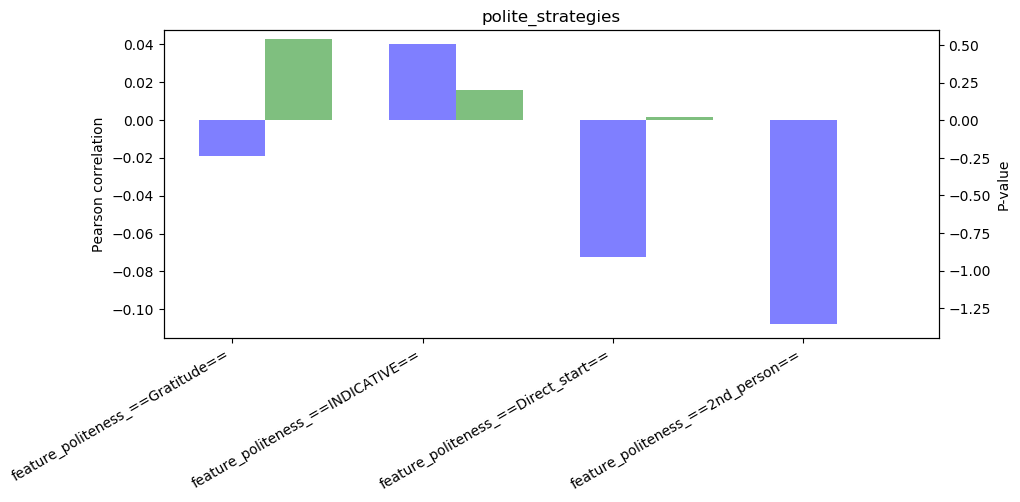

In [499]:
# statics[1]

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
# plot all data
y_pos = np.arange(len(polite_strategies))
performance = [i[0] for i in statics]

#plot_sub polite strategy
sub_polite_strategies_list = [6, 17, 15,  11]
sub_polite_strategies = np.array(polite_strategies)[sub_polite_strategies_list]
y_pos = np.arange(len(sub_polite_strategies))
performance = np.array([i[0] for i in statics])[sub_polite_strategies_list]
p_value = np.array([i[1] for i in statics])[sub_polite_strategies_list]

fig, ax1 = plt.subplots()
fig.set_size_inches(10, 4)
bar_width = 0.35
opacity = 0.8
# plt.bar(y_pos, performance, align='center', alpha=0.5)
ax1.bar(y_pos, performance, bar_width,alpha=0.5,color='b',label='correlation')
ax1.set_ylabel("Pearson correlation")
plt.xticks(y_pos, sub_polite_strategies)

ax2 = ax1.twinx()  #par1 = ax1.twinx()
ax2.bar(y_pos + bar_width, p_value, bar_width,alpha=0.5,color='g',label='p-value')
ax2.set_ylim(-1.45, 0.6)
ax2.set_ylabel('P-value')
plt.title('polite_strategies')

plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [498]:
polite_strategies

['feature_politeness_==Please==',
 'feature_politeness_==Please_start==',
 'feature_politeness_==Indirect_(btw)==',
 'feature_politeness_==Hedges==',
 'feature_politeness_==Factuality==',
 'feature_politeness_==Deference==',
 'feature_politeness_==Gratitude==',
 'feature_politeness_==Apologizing==',
 'feature_politeness_==1st_person_pl.==',
 'feature_politeness_==1st_person==',
 'feature_politeness_==1st_person_start==',
 'feature_politeness_==2nd_person==',
 'feature_politeness_==2nd_person_start==',
 'feature_politeness_==Indirect_(greeting)==',
 'feature_politeness_==Direct_question==',
 'feature_politeness_==Direct_start==',
 'feature_politeness_==SUBJUNCTIVE==',
 'feature_politeness_==INDICATIVE==',
 'feature_politeness_==HASHEDGE==',
 'feature_politeness_==HASPOSITIVE==',
 'feature_politeness_==HASNEGATIVE==']

In [ ]:
ds